In [98]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [127]:
%load_ext lab_black

In [107]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1079]:
import pandas as pd
import lightgbm

import matplotlib.pyplot as plt
import altair as alt
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

from hm_fashion.model import get_ranker_pipeline
import mlflow
import mlflow.lightgbm

In [101]:
pd.options.display.float_format = "{:.2f}".format

In [1078]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.create_experiment("kaggle")

'1'

In [1118]:
mlflow.lightgbm.autolog(disable=True)
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

## Load Training and Validation Data

In [1331]:
%%bigquery training_data --project zenscr-seefood-dev

WITH base AS (
  SELECT
    *
  FROM `zenscr-seefood-dev.hm_kaggle_reco.training_data` t 
  WHERE (article_similarity_score > 0 OR article_sales_score > 0 OR prev_purchases_score > 0 OR prev_purchases_score > 0 OR article_department_sales_score > 0)  AND (obs_dat <= "2020-09-09")
),
positive_samples AS (
    SELECT * FROM base WHERE relevance = 1
),
negative_samples AS (
    SELECT * FROM base 
    WHERE relevance = 0 AND ABS(MOD(FARM_FINGERPRINT(obs_dat  || customer_short_id || article_id), 100)) <= 5
),
all_samples AS (
    SELECT * FROM positive_samples
    UNION ALL
    SELECT * FROM negative_samples
),
filtered AS (
  SELECT
    t.*,
    MAX(relevance) OVER (PARTITION BY obs_dat, customer_short_id) max_relevance,
    COUNT(*) OVER (PARTITION BY obs_dat, customer_short_id) num_trans
  FROM all_samples t 
  QUALIFY max_relevance = 1 AND num_trans > 1 
)

SELECT
  * EXCEPT(max_relevance, num_trans)
FROM filtered

Downloading: 100%|████████████████████████████████████████████████████████████| 3335508/3335508 [00:41<00:00, 80520.46rows/s]


In [1332]:
training_data.shape

(3335508, 34)

In [1333]:
%%bigquery validation_data --project zenscr-seefood-dev

WITH base AS (
  SELECT
    *
  FROM `zenscr-seefood-dev.hm_kaggle_reco.training_data` t 
  WHERE (article_similarity_score > 0 OR article_sales_score > 0 OR prev_purchases_score > 0 OR prev_purchases_score > 0 OR article_department_sales_score > 0) AND (obs_dat = "2020-09-16")
),
filtered AS (
  SELECT
    t.*,
    MAX(relevance) OVER (PARTITION BY obs_dat, customer_short_id) max_relevance,
    COUNT(*) OVER (PARTITION BY obs_dat, customer_short_id) num_trans
  FROM base t 
  QUALIFY max_relevance = 1 AND num_trans > 1 
)

SELECT
  * EXCEPT(max_relevance, num_trans)
FROM filtered

Downloading: 100%|████████████████████████████████████████████████████████████| 2090962/2090962 [00:25<00:00, 81081.45rows/s]


In [1305]:
validation_data.shape

(2090709, 34)

In [1306]:
training_data.isna().mean()

obs_dat                                    0.00
customer_short_id                          0.00
article_id                                 0.00
relevance                                  0.00
article_similarity_score                   0.00
article_sales_score                        0.00
prev_purchases_score                       0.00
article_department_sales_score             0.00
obs_month                                  0.00
feat_customer_age                          0.09
feat_customer_price_affinity               0.09
feat_customer_stdev_price                  0.10
feat_customer_num_purchases                0.09
feat_customer_last_purchase_num_days       0.09
feat_customer_club_member_status           0.09
feat_customer_active                       0.59
feat_customer_fashion_news_frequency       0.09
feat_customer_sales_channel_one_affinity   0.09
feat_customer_sales_channel_two_affinity   0.09
feat_article_avg_price_1day                0.00
feat_article_avg_price_3days            

In [1347]:
validation_data.isna().mean()

obs_dat                                    0.00
customer_short_id                          0.00
article_id                                 0.00
relevance                                  0.00
article_similarity_score                   0.00
article_sales_score                        0.00
prev_purchases_score                       0.00
article_department_sales_score             0.00
obs_month                                  0.00
feat_customer_age                          0.08
feat_customer_price_affinity               0.08
feat_customer_stdev_price                  0.10
feat_customer_num_purchases                0.08
feat_customer_last_purchase_num_days       0.08
feat_customer_club_member_status           0.08
feat_customer_active                       0.59
feat_customer_fashion_news_frequency       0.08
feat_customer_sales_channel_one_affinity   0.08
feat_customer_sales_channel_two_affinity   0.08
feat_article_avg_price_1day                0.14
feat_article_avg_price_3day             

## Explore Training Data

<AxesSubplot:xlabel='obs_dat'>

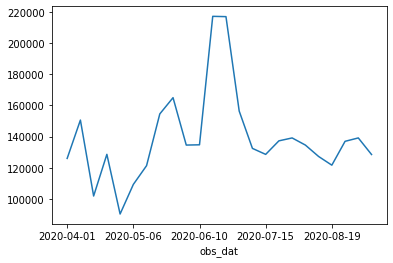

In [1307]:
training_data.groupby("obs_dat")["relevance"].count().plot.line()

In [1308]:
training_data.groupby(["obs_dat", "customer_short_id"]).agg(
    num_items=("relevance", "count"), num_pos=("relevance", "sum")
).describe()

,num_items,num_pos
count,26792.00,26792.00
mean,124.46,2.28
std,11.24,1.86
min,81.00,1.00
25%,117.00,1.00
50%,124.00,2.00
75%,132.00,3.00
max,174.00,28.00


In [1309]:
validation_data.groupby(["obs_dat", "customer_short_id"]).agg(
    num_items=("relevance", "count"), num_pos=("relevance", "sum")
).describe()

,num_items,num_pos
count,1021.00,1021.00
mean,2047.71,2.16
std,57.91,1.79
min,2000.00,1.00
25%,2009.00,1.00
50%,2029.00,2.00
75%,2065.00,3.00
max,2456.00,16.00


In [1310]:
training_data["relevance"].value_counts()

0    3273579
1      60980
Name: relevance, dtype: Int64

<AxesSubplot:ylabel='Frequency'>

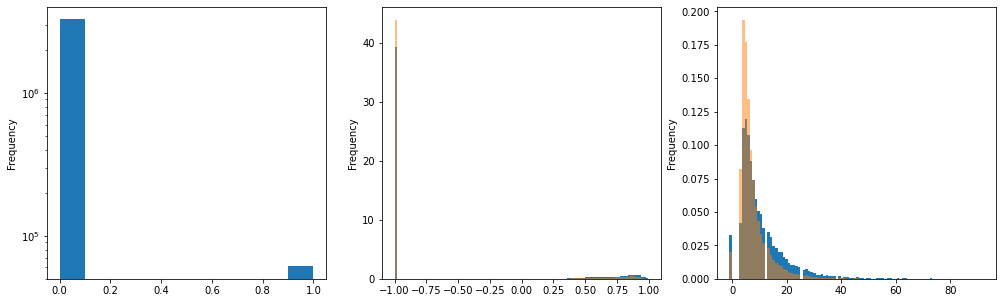

In [1311]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

training_data["relevance"].plot.hist(log=True, ax=axs[0])

training_data[lambda d: d["relevance"] == 1]["article_similarity_score"].plot.hist(
    density=True, bins=100, ax=axs[1]
)
training_data[lambda d: d["relevance"] == 0]["article_similarity_score"].plot.hist(
    density=True, alpha=0.5, bins=100, ax=axs[1]
)

training_data[lambda d: d["relevance"] == 1]["article_sales_score"].plot.hist(
    density=True, bins=100, ax=axs[2]
)
training_data[lambda d: d["relevance"] == 0]["article_sales_score"].plot.hist(
    density=True, alpha=0.5, bins=100, ax=axs[2]
)

## Model Training

In [1334]:
features = [
    "article_similarity_score",
    "article_sales_score",
    "prev_purchases_score",
    "obs_month",
    "feat_customer_age",
    "feat_customer_price_affinity",
    "feat_customer_stdev_price",
    "feat_customer_num_purchases",
    "feat_customer_last_purchase_num_days",
    "feat_customer_club_member_status",
    "feat_customer_active",
    "feat_customer_fashion_news_frequency",
    "feat_customer_sales_channel_one_affinity",
    "feat_customer_sales_channel_two_affinity",
    "feat_article_avg_price_1day",
    "feat_article_avg_price_3day",
    "feat_article_avg_price_7day",
    "feat_article_num_sales_1day",
    "feat_article_num_sales_3day",
    "feat_article_num_sales_7day",
    "feat_article_avg_customer_age",
    "feat_article_product_type_no",
    "feat_article_graphical_appearance_no",
    "feat_article_colour_group_code",
    "feat_article_perceived_colour_value_id",
    "feat_article_perceived_colour_master_id",
    # "feat_article_index_code",
    "feat_article_section_no",
    "feat_article_garment_group_no",
]

pipe = get_ranker_pipeline(features)

In [1335]:
model = pipe[-1]

In [1336]:
pipe

Pipeline(steps=[('features',
                 Pipeline(steps=[('to_dataframe',
                                  FunctionTransformer(func=<function to_dataframe at 0x13cccbb80>,
                                                      kw_args={'col_labels': ['article_similarity_score',
                                                                              'article_sales_score',
                                                                              'prev_purchases_score',
                                                                              'obs_month',
                                                                              'feat_customer_age',
                                                                              'feat_customer_price_affinity',
                                                                              'feat_customer_stdev_price',
                                                                              'feat_customer_num_purchases

In [1337]:
df_train = (
    training_data.groupby(["obs_dat", "customer_short_id"], sort=False)
    .apply(lambda g: g.sample(frac=1))
    .reset_index(drop=True)
)
X_train = pipe[:-1].fit_transform(df_train).astype("float64")
y_train = df_train["relevance"].astype("int32")
qids_train = (
    df_train.groupby(["obs_dat", "customer_short_id"])["relevance"].count().to_numpy()
)

X_train.shape, len(y_train), len(qids_train)

((3335508, 28), 3335508, 26800)

In [1338]:
df_val = (
    validation_data.groupby(["obs_dat", "customer_short_id"], sort=False)
    .apply(lambda g: g.sample(frac=1))
    .reset_index(drop=True)
)
X_val = pipe[:-1].fit_transform(df_val).astype("float64")
y_val = df_val["relevance"].astype("int32")
qids_val = (
    df_val.groupby(["obs_dat", "customer_short_id"])["relevance"].count().to_numpy()
)

X_val.shape, len(y_val), len(qids_val)

((2090962, 28), 2090962, 1021)

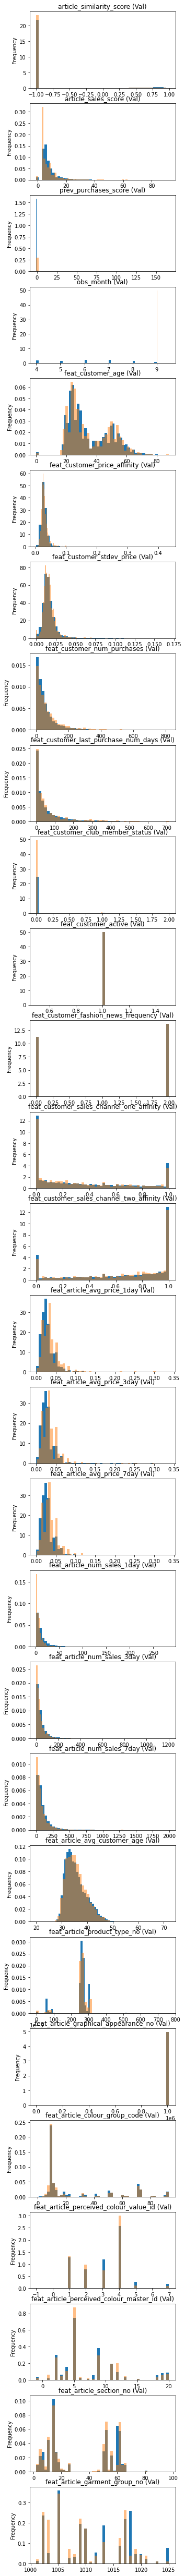

In [1339]:
fig, axs = plt.subplots(len(features), 1, figsize=(5, 90))

for i, feat in enumerate(features):
    X_train[feat].plot.hist(bins=50, ax=axs[i], title=f"{feat} (Train)", density=True)
    X_val[feat].plot.hist(
        bins=50, ax=axs[i], title=f"{feat} (Val)", density=True, alpha=0.5
    )

In [1351]:
model.set_params(n_estimators=50).fit(
    X=X_train[features],
    y=y_train,
    group=qids_train,
    eval_metric=["ndcg", "map"],
    eval_set=[(X_train[features], y_train), (X_val[features], y_val)],
    eval_group=[qids_train, qids_val],
    eval_at=12,
    callbacks=[lightgbm.log_evaluation()],
)

[1]	valid_0's map@12: 0.210857	valid_0's ndcg@12: 0.28281	valid_1's map@12: 0.107785	valid_1's ndcg@12: 0.125263
[2]	valid_0's map@12: 0.219097	valid_0's ndcg@12: 0.291905	valid_1's map@12: 0.108914	valid_1's ndcg@12: 0.127593
[3]	valid_0's map@12: 0.223123	valid_0's ndcg@12: 0.296122	valid_1's map@12: 0.10977	valid_1's ndcg@12: 0.128465
[4]	valid_0's map@12: 0.224161	valid_0's ndcg@12: 0.297545	valid_1's map@12: 0.109863	valid_1's ndcg@12: 0.128686
[5]	valid_0's map@12: 0.225812	valid_0's ndcg@12: 0.299408	valid_1's map@12: 0.109688	valid_1's ndcg@12: 0.128998
[6]	valid_0's map@12: 0.22635	valid_0's ndcg@12: 0.300337	valid_1's map@12: 0.110211	valid_1's ndcg@12: 0.129573
[7]	valid_0's map@12: 0.226519	valid_0's ndcg@12: 0.300463	valid_1's map@12: 0.111213	valid_1's ndcg@12: 0.130574
[8]	valid_0's map@12: 0.227179	valid_0's ndcg@12: 0.30136	valid_1's map@12: 0.110776	valid_1's ndcg@12: 0.130185
[9]	valid_0's map@12: 0.227704	valid_0's ndcg@12: 0.301828	valid_1's map@12: 0.111201	valid_

LGBMRanker(metric='ndcg', n_estimators=50, objective='lambdarank')

In [1341]:
df_eval_results = (
    pd.DataFrame(
        {
            "train_valid_map": model.evals_result_["valid_0"]["map@12"],
            "train_valid_ndcg": model.evals_result_["valid_0"]["ndcg@12"],
            "val_valid_map": model.evals_result_["valid_1"]["map@12"],
            "val_valid_ndcg": model.evals_result_["valid_1"]["ndcg@12"],
        }
    )
    .reset_index()
    .rename({"index": "iteration"}, axis=1)
    .melt(
        id_vars="iteration",
        value_vars=[
            "train_valid_map",
            "train_valid_ndcg",
            "val_valid_map",
            "val_valid_ndcg",
        ],
    )
)

#### Training

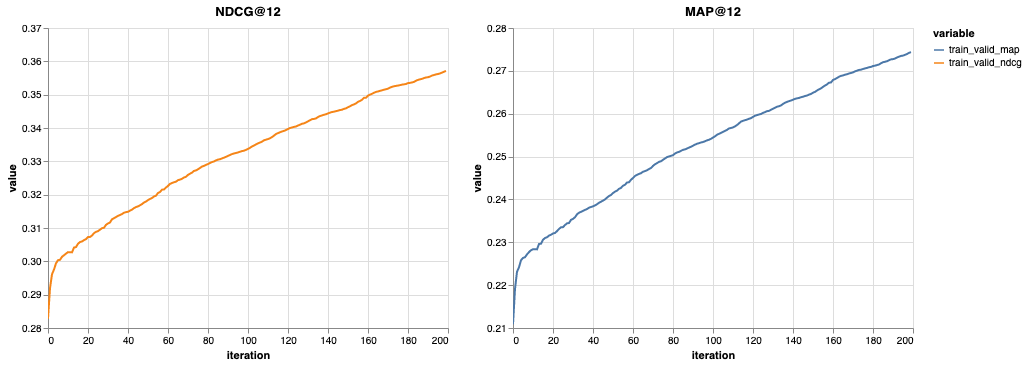

In [1361]:
alt_ndcg = (
    alt.Chart(
        df_eval_results[lambda d: d["variable"].isin(["train_valid_ndcg"])],
        title="NDCG@12",
    )
    .mark_line()
    .encode(
        x="iteration",
        y=alt.Y("value", scale=alt.Scale(domain=(0.28, 0.37))),
        color="variable",
    )
).interactive()

alt_map = (
    alt.Chart(
        df_eval_results[lambda d: d["variable"].isin(["train_valid_map"])],
        title="MAP@12",
    )
    .mark_line()
    .encode(
        x="iteration",
        y=alt.Y("value", scale=alt.Scale(domain=(0.21, 0.28))),
        color="variable",
    )
).interactive()

alt_ndcg | alt_map

#### Validation

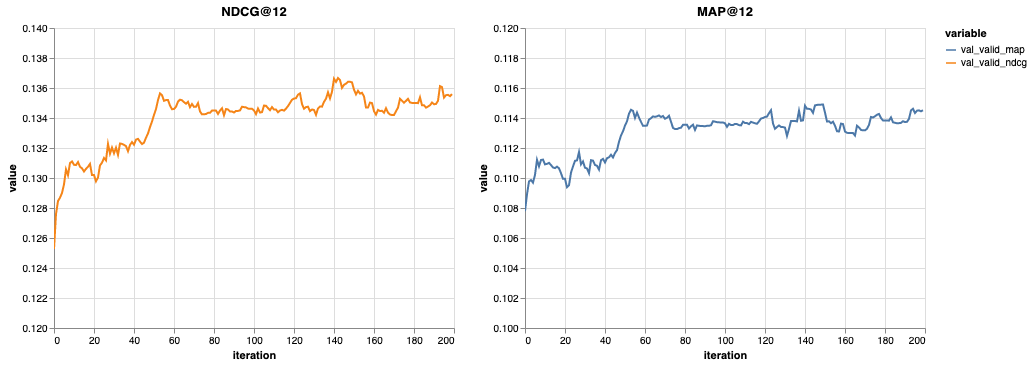

In [1359]:
alt_ndcg = (
    alt.Chart(
        df_eval_results[lambda d: d["variable"].isin(["val_valid_ndcg"])],
        title="NDCG@12",
    )
    .mark_line()
    .encode(
        x="iteration",
        y=alt.Y("value", scale=alt.Scale(domain=(0.12, 0.14))),
        color="variable",
    )
).interactive()

alt_map = (
    alt.Chart(
        df_eval_results[lambda d: d["variable"].isin(["val_valid_map"])],
        title="MAP@12",
    )
    .mark_line()
    .encode(
        x="iteration",
        y=alt.Y("value", scale=alt.Scale(domain=(0.10, 0.12))),
        color="variable",
    )
).interactive()

alt_ndcg | alt_map

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

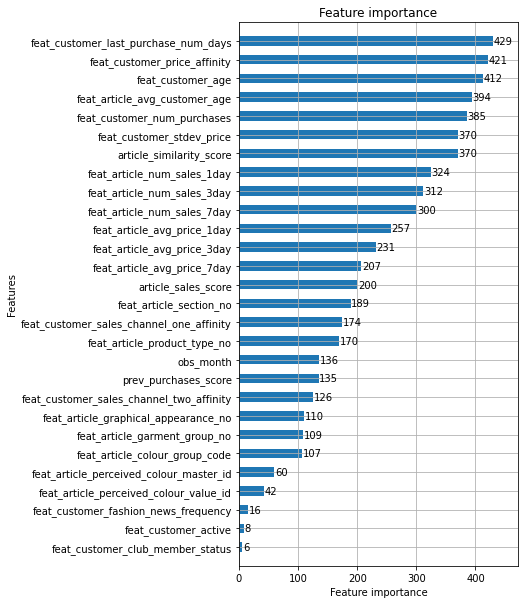

In [1343]:
lightgbm.plot_importance(model, figsize=(5, 10), height=0.5)

## SHAP

In [1344]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val[features].sample(5000))

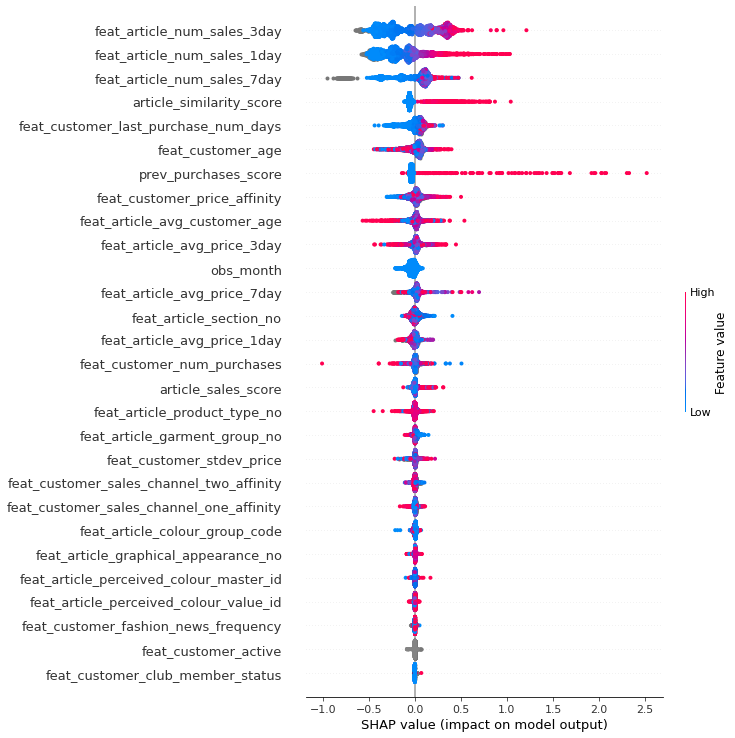

In [1345]:
shap.plots.beeswarm(shap_values, max_display=30)

## Write to MLFlow

In [1348]:
with mlflow.start_run():
    mlflow.log_metric("train_map12", model.best_score_["valid_0"]["map@12"])
    mlflow.log_metric("train_ndcg12", model.best_score_["valid_0"]["ndcg@12"])
    mlflow.log_metric("val_map12", model.best_score_["valid_1"]["map@12"])
    mlflow.log_metric("val_ndcg12", model.best_score_["valid_1"]["ndcg@12"])

## Cross Validation

In [1022]:
obs_dates = df_train["obs_dat"].sort_values().unique()
obs_dates

<DateArray>
[ datetime.date(2020, 4, 1),  datetime.date(2020, 4, 8),
 datetime.date(2020, 4, 15), datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 29),  datetime.date(2020, 5, 6),
 datetime.date(2020, 5, 13), datetime.date(2020, 5, 20),
 datetime.date(2020, 5, 27),  datetime.date(2020, 6, 3),
 datetime.date(2020, 6, 10), datetime.date(2020, 6, 17),
 datetime.date(2020, 6, 24),  datetime.date(2020, 7, 1),
  datetime.date(2020, 7, 8), datetime.date(2020, 7, 15),
 datetime.date(2020, 7, 22), datetime.date(2020, 7, 29),
  datetime.date(2020, 8, 5), datetime.date(2020, 8, 12),
 datetime.date(2020, 8, 19), datetime.date(2020, 8, 26),
  datetime.date(2020, 9, 2),  datetime.date(2020, 9, 9)]
Length: 24, dtype: dbdate

In [1017]:
obs_dates.shape

(24,)

In [1049]:
tscv = TimeSeriesSplit(5)

In [1050]:
for train_index, test_index in tscv.split(obs_dates):
    train = df_train[df_train["obs_dat"].isin(obs_dates[train_index])]
    print(train.shape)
    test = df_train[df_train["obs_dat"].isin(obs_dates[test_index])]

(120345, 22)
(212252, 22)
(319910, 22)
(412757, 22)
(472965, 22)


In [1006]:
df_train

,obs_dat,customer_short_id,article_id,relevance,article_similarity_score,article_sales_score,prev_purchases_score,article_department_sales_score,feat_customer_age,feat_customer_price_affinity,...,feat_article_stdev_price,feat_article_num_sales,feat_article_num_distinct_customers,feat_article_average_age,feat_article_stdev_age,feat_article_colour_group_code,feat_article_perceived_colour_value_id,feat_article_section_no,feat_article_index_code,feat_article_garment_group_no
0,2020-04-01,193594,848422001,0,0.80,3.00,-1.00,-1.00,24.00,0.03,...,0.01,3,2,35.67,9.81,9,4,15,A,1005
1,2020-04-01,193594,835704003,0,0.59,3.00,-1.00,-1.00,24.00,0.03,...,0.00,3,2,28.67,2.89,93,2,61,B,1017
2,2020-04-01,193594,218829002,0,-1.00,-1.00,1.00,-1.00,24.00,0.03,...,0.00,42,39,33.71,12.42,9,4,65,C,1019
3,2020-04-01,193594,752689002,0,0.36,5.00,-1.00,-1.00,24.00,0.03,...,0.00,36,29,35.17,12.70,9,4,51,D,1017
4,2020-04-01,193594,706016019,0,0.64,12.00,-1.00,-1.00,24.00,0.03,...,0.00,95,74,35.29,11.91,73,4,53,D,1009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515511,2020-09-09,348022,720125001,0,0.49,3.00,-1.00,-1.00,32.00,0.04,...,0.00,417,360,33.37,12.90,9,4,5,S,1005
515512,2020-09-09,348022,718278001,0,0.52,7.00,-1.00,-1.00,32.00,0.04,...,0.00,142,119,34.99,13.66,9,4,51,D,1002
515513,2020-09-09,348022,833530002,0,0.93,6.00,-1.00,-1.00,32.00,0.04,...,0.00,87,71,31.41,11.65,73,4,60,B,1018
515514,2020-09-09,348022,841383003,0,0.46,15.00,-1.00,-1.00,32.00,0.04,...,0.00,167,117,39.41,12.71,10,3,16,A,1002
